## Processing data without staurosporine

### Preprocessing

In [1]:
import os
import numpy as np
import pandas as pd

def add_gene_name(data):   
    desp = data['Description'].values
    gene = []
    for s in desp:
        
        g = s[s.find('GN=') + 3:].split(' ')[0]
        gene.append(g)
    data['Gene Symbol'] = gene
    return data


def preprocess_single(data):
    columns = ['Accession',
               '# PSMs',
               'Gene Symbol']
    val_cols = [s for s in data.columns if 'Abundances (Normalized):' in s]
    val_cols = val_cols[:len(val_cols)-2]
    columns += val_cols
    new_data = data[columns]
    new_columns = columns[:3] + ['Abundances_Pool_{}'.format(i) for i in range(9)]
    new_data.columns = new_columns
    return new_data


# load raw data
ptable = pd.read_csv('data/NoStauro/protein_table.csv')

# preprocessing
ptable = add_gene_name(ptable)
new_ptable = preprocess_single(ptable)

# save data
new_ptable.to_csv('data/NoStauro/preprocessed_table.csv', index = False)

### Statistical analysis with LASSO

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from core.core import *

pool_matrix = pd.read_excel('data/NoStauro/sensing_matrix.xlsx')
pool_matrix = pool_matrix.fillna(0)

scores, fold_changes = post_analysis(new_ptable, pool_matrix, drug_num = 3)

scores.to_csv('data/NoStauro/scores.csv')
fold_changes.to_csv('data/NoStauro/fold_changes.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 3580/3580 [00:05<00:00, 650.78it/s]


### Result of verification set

            drug  target  rank             mark
0    Palbociclib    CDK4     2    1 > rank >= 5
1    Palbociclib    CDK6     5    1 > rank >= 5
2   Panobinostat   HDAC1     1         rank = 1
3   Panobinostat   HDAC2     3    1 > rank >= 5
4   Fimepinostat   HDAC1     1         rank = 1
5   Fimepinostat   HDAC2    11  10 > rank >= 25
6    Raltitrexed    TYMS     1         rank = 1
7   Methotrexate    DHFR     1         rank = 1
8    Vemurafenib    BRAF     3    1 > rank >= 5
9       SCIO-469  MAPK14     1         rank = 1
10        SL-327  MAP2K1     2    1 > rank >= 5
11        SL-327  MAP2K2     1         rank = 1
12      Olaparib   PARP1  3541        rank > 25


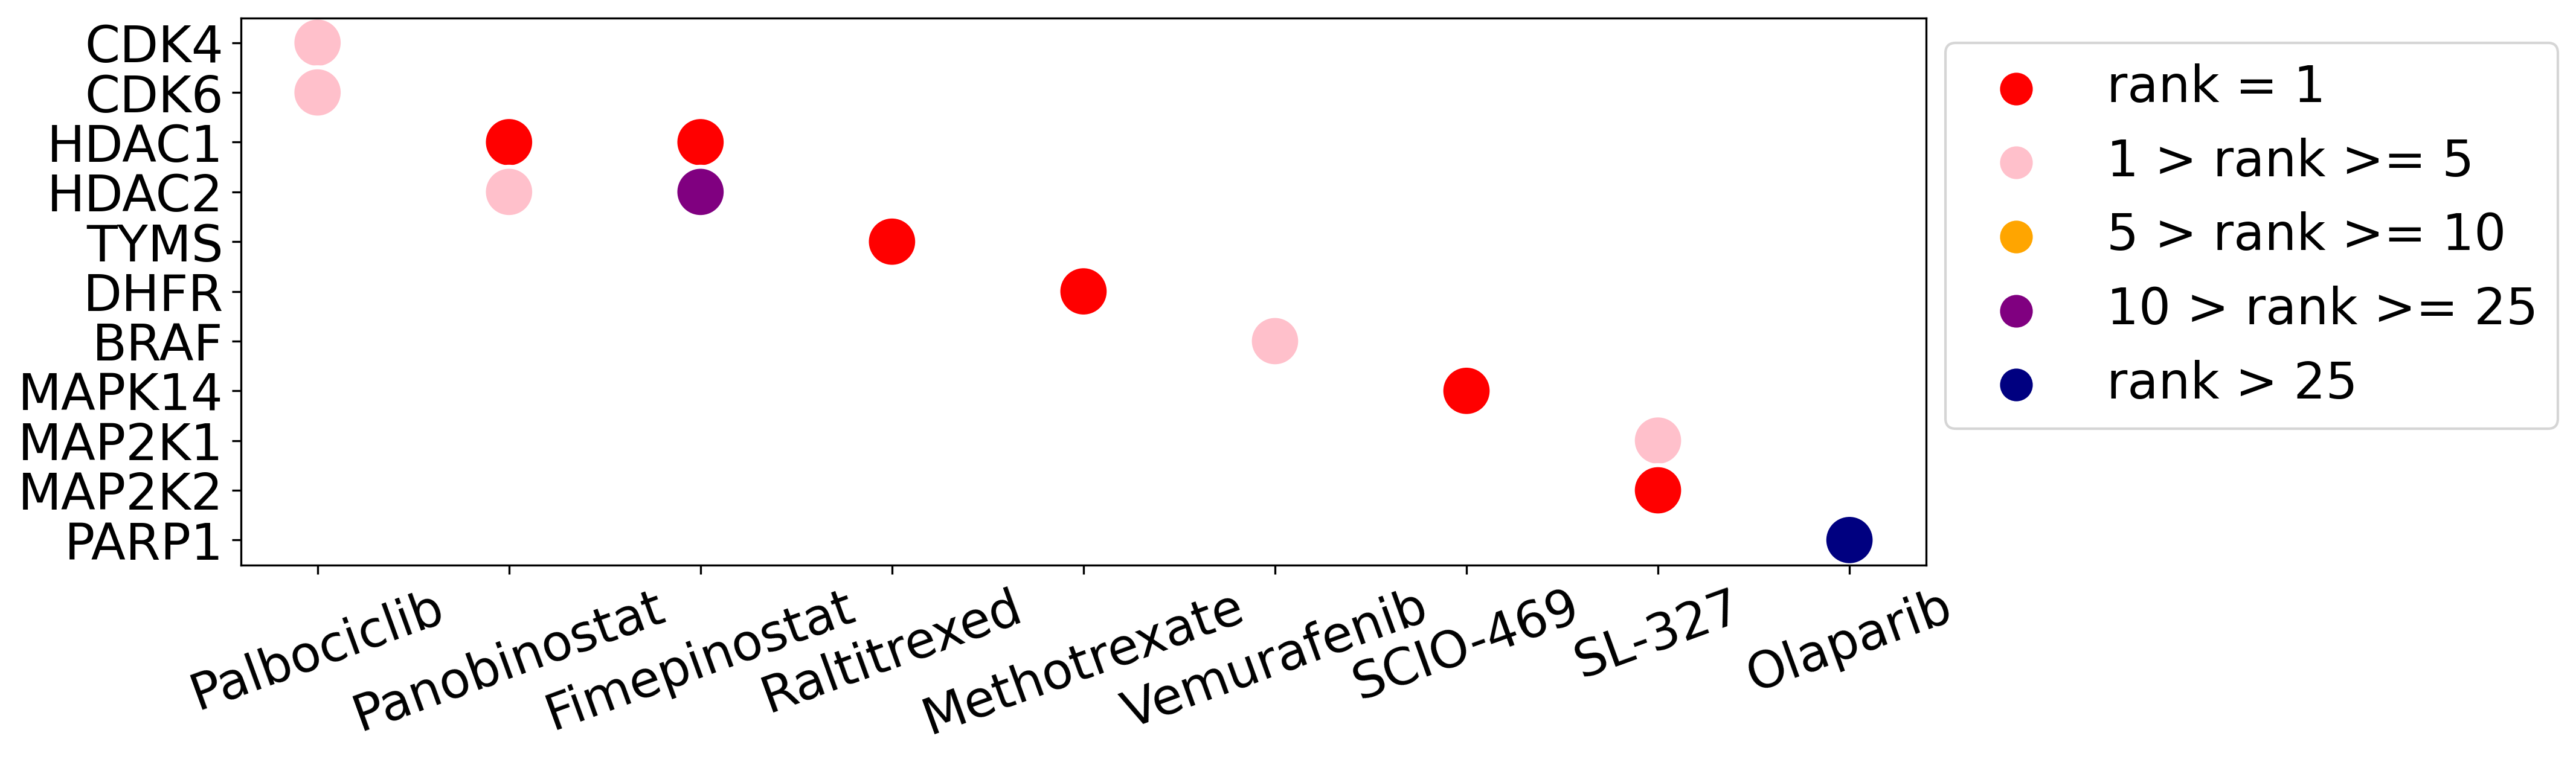

In [3]:
drug_targets = {'Palbociclib': ['CDK4', 'CDK6'], 
                'Panobinostat': ['HDAC1', 'HDAC2'],
                'Fimepinostat': ['HDAC1', 'HDAC2'],
                'Raltitrexed': ['TYMS'], 
                'Methotrexate': ['DHFR'], 
                'Vemurafenib': ['BRAF'],
                'SCIO-469': ['MAPK14'],
                'SL-327': ['MAP2K1', 'MAP2K2'],
                'Olaparib': ['PARP1']}

def plat_target_ranking(scores, drug_targets):
    plt_data = []
    for drug, target in drug_targets.items():
        for t in target:
            w = np.where(scores['Gene Symbol'] == t)[0][0]
            if drug not in scores.columns:
                rank = np.nan
                mark = str('not included')
                plt_data.append([drug, t, rank, mark])
                continue
            score = scores[drug][w]
            rank = len(np.where(scores[drug] >= score)[0])
            if rank > 25:
                mark = 'rank > 25'
            elif rank > 10:
                mark = '10 > rank >= 25'
            elif rank > 5:
                mark = '5 > rank >= 10'
            elif rank > 1:
                mark = '1 > rank >= 5'
            else:
                mark = 'rank = 1'
            plt_data.append([drug, t, rank, mark])
    plt_data = pd.DataFrame(plt_data)
    plt_data.columns = ['drug', 'target', 'rank', 'mark']
    print(plt_data)
    
    flatui = ['red', 'pink', 'orange', 'purple', 'navy']
    hue_order = ['rank = 1', '1 > rank >= 5', '5 > rank >= 10', '10 > rank >= 25', 'rank > 25']
    my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

    plt.figure(dpi = 300, figsize = (12, 4))
    sns.scatterplot(x='drug', y='target', hue='mark', data=plt_data, s = 400, palette = my_cmap.colors,
                    hue_order = hue_order)
    plt.xticks(fontsize = 20, rotation=20)
    plt.yticks(fontsize = 20)
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(loc='upper right', bbox_to_anchor=(1.39, 1), fontsize = 20, markerscale = 2)

plat_target_ranking(scores, drug_targets)

### Result of exploratory set

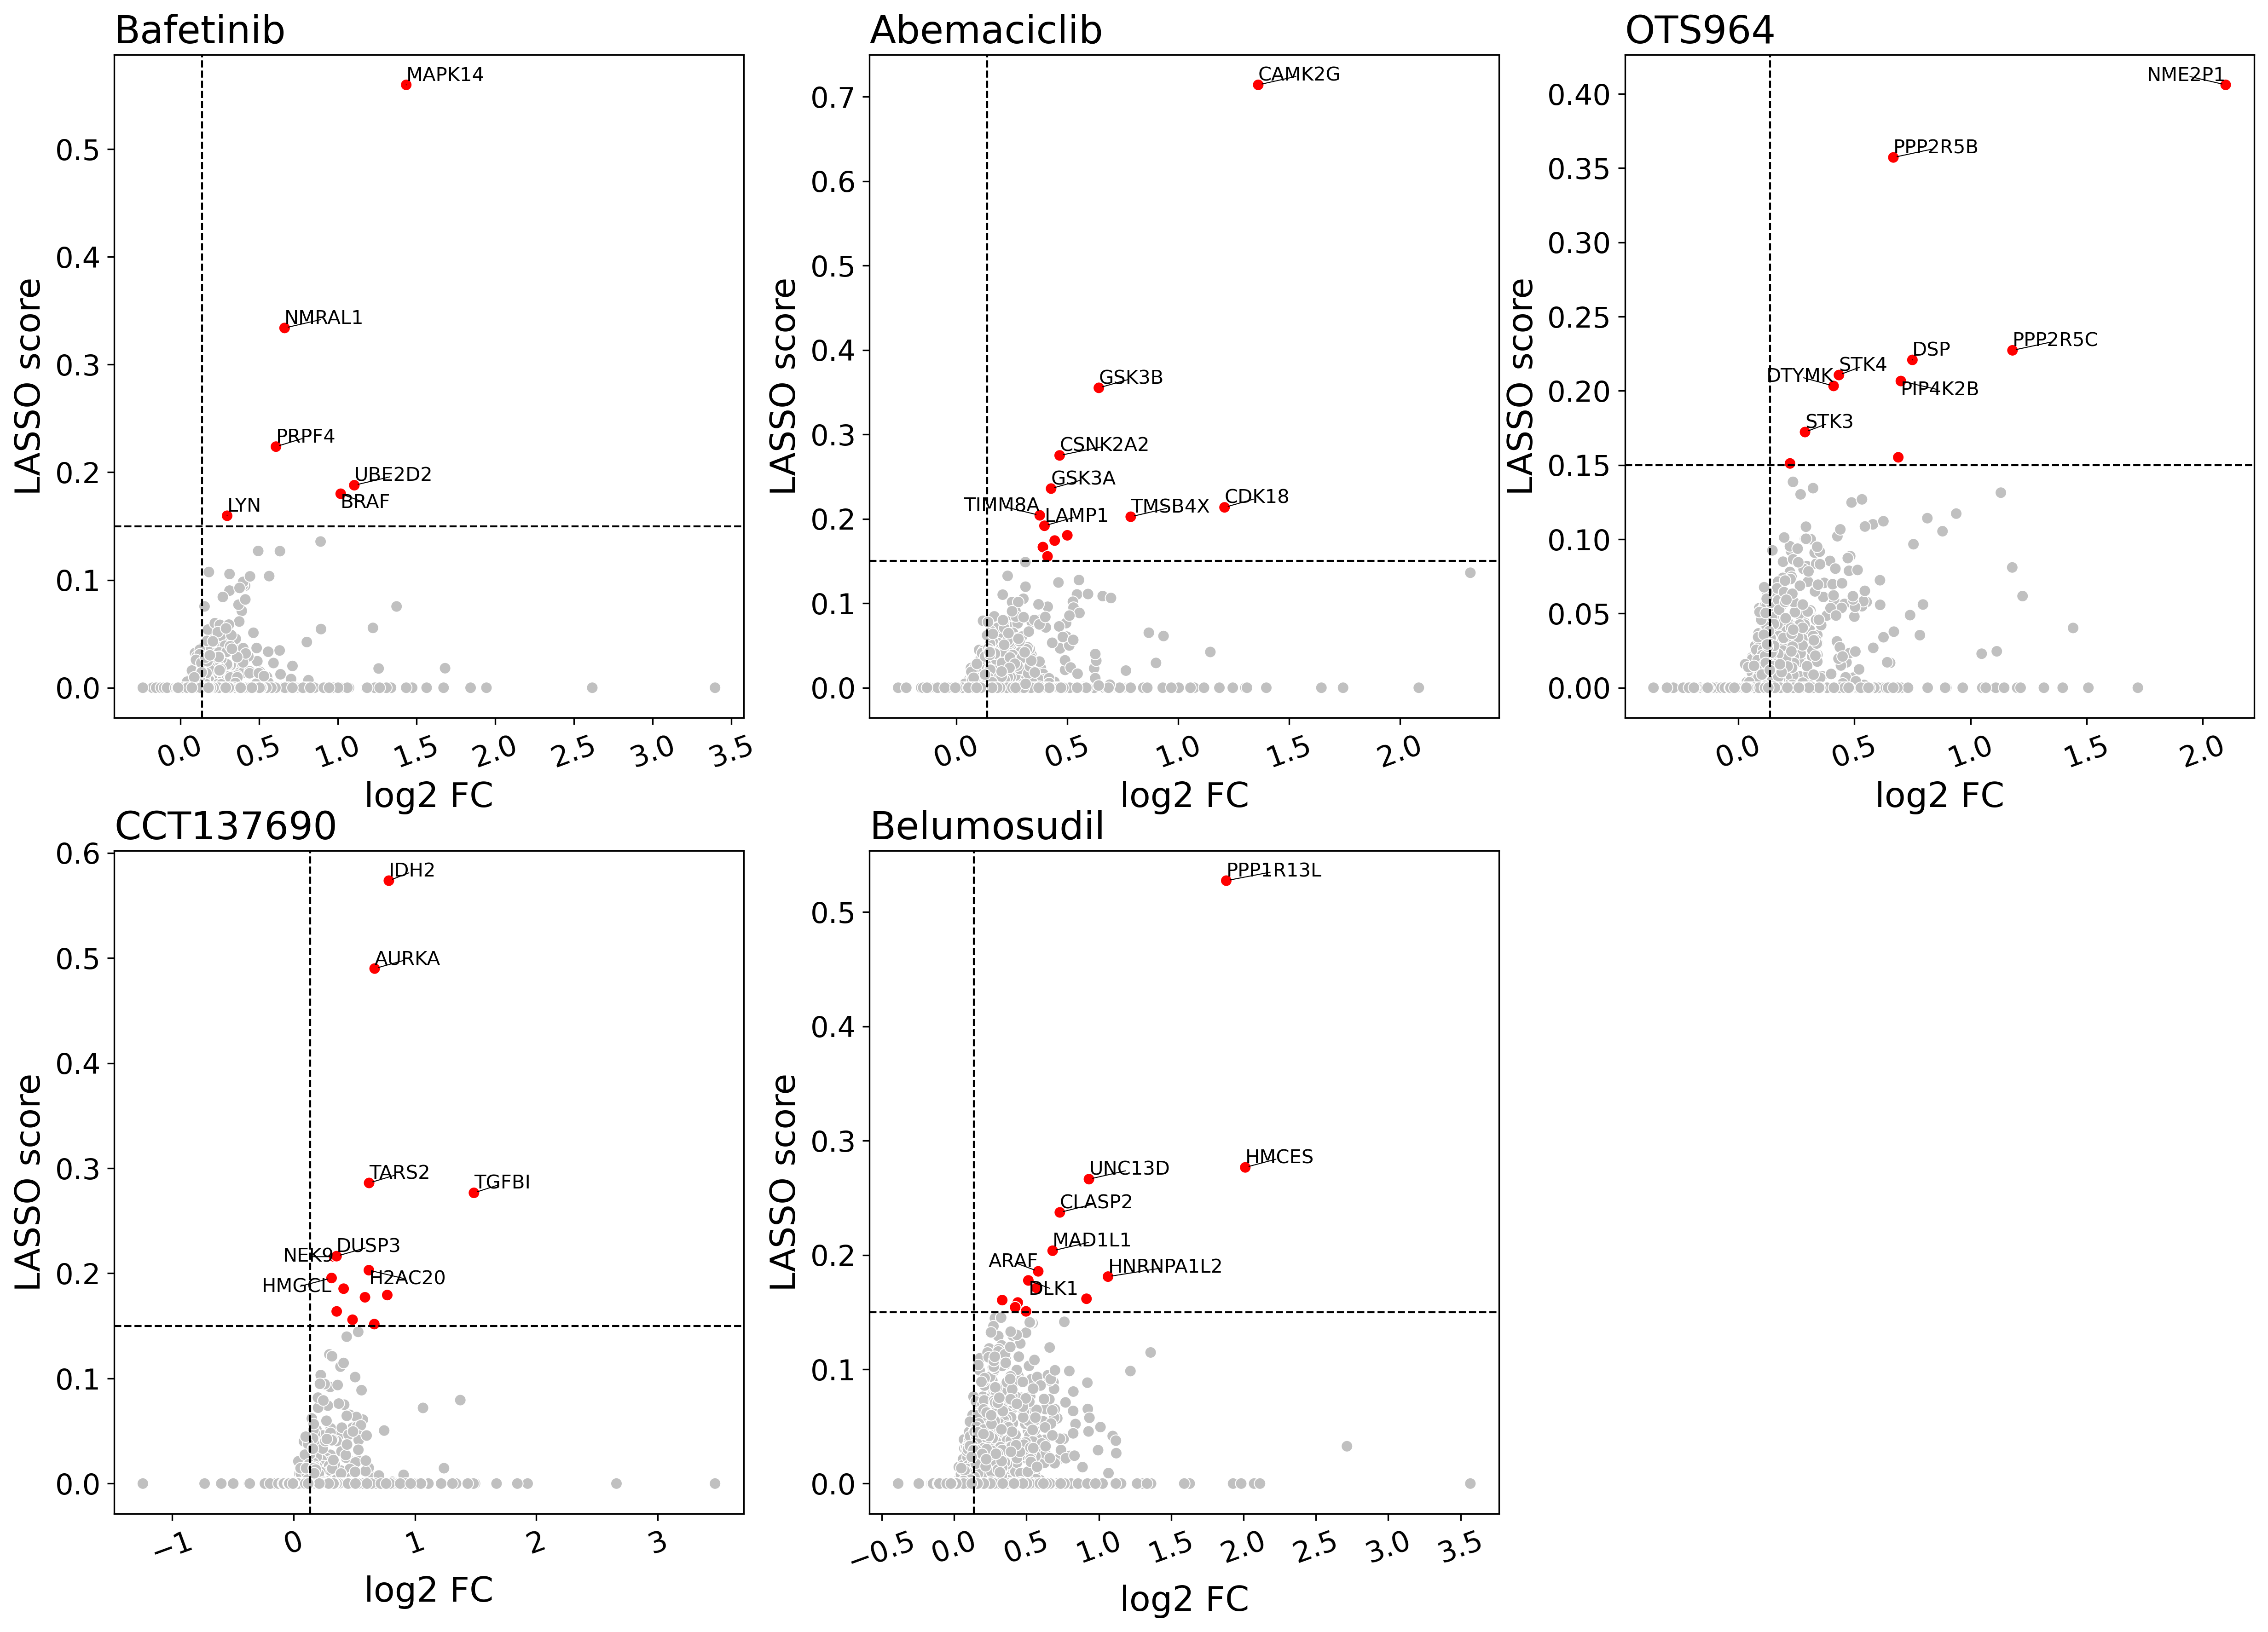

In [4]:
# define the drugs
drugs = ['Bafetinib', 'Abemaciclib', 'OTS964', 'CCT137690', 'Belumosudil']

# plot the result
plt.figure(dpi = 300, figsize = (20, 14))
for i, d in enumerate(drugs):
    plt.subplot(2,3,1+i)
    plot_results(d, scores, fold_changes, fc_thres = 1.1, score_thres=0.15, top_markers = 8)